# RL Information
This notebook is used to produce the necessary information needed evaluate the RL performance of the agent and clinicians

## Import Necessary Libraries

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

## Load RL Data

In [2]:
df = pd.read_parquet('data/ped_rl_train.parquet.gzip')    

## Calculate Rewards Based on Clinicians' Performance

In [13]:
csns = df['csn'].unique()
mort_csns = df.loc[df['mortality_flag'] == 1, 'csn'].unique()

# map action values to action space
fio2_bins = [21, 30, 40, 50, 60, 70, 80, 90, 101]
fio2_labels = [0, 1, 2, 3, 4, 5, 6, 7]

peep_bins = [1, 5, 9, 13, 16, 101]
peep_labels = [0, 1, 2, 3, 4]

vent_rate_bins = [2, 7, 12, 17, 25, 35]
vent_rate_labels = [0, 1, 2, 3, 4]

df['fio2_action'] = pd.cut(df['fio2'], bins=fio2_bins, labels=fio2_labels, right=False)
df['peep_action'] = pd.cut(df['peep'], bins=peep_bins, labels=peep_labels, right=False)
df['vent_rate_action'] = pd.cut(df['vent_rate_set'], bins=vent_rate_bins, labels=vent_rate_labels, right=False)

actions=[fio2_labels, peep_labels, vent_rate_labels]
total_actions = list(itertools.product(*actions))
actions_map = {action: i for i, action in enumerate(total_actions)}
df['action'] = [actions_map[x] for x in tuple(zip(df['fio2_action'], df['peep_action'], df['vent_rate_action']))]

# define short term and long term rewards
df['sofa_reward'] = 2 * df['psofa_resp'] + df['psofa_renal'] + df['psofa_card']
df['short_term_reward'] = df.groupby(['csn'])['sofa_reward'].diff().fillna(0)
df['long_term_reward'] = np.where(df['csn'].isin(mort_csns), -10, 10)

# save to file
save_vars = ['csn', 'state', 'fio2_action', 'peep_action', 'vent_rate_action', 'action', 'mortality_flag', 'short_term_reward', 'long_term_reward']

rl_df = df[save_vars]

## Create Transition Probability Matrix

In [14]:
def create_tran_prob_matrix(df, num_actions):
    df = df.copy()
    num_states = len(df['state'].unique())
    tran_counts = np.zeros((num_states+2, num_states+2, num_actions))
    csns = df['csn'].unique()
    mort_csns = df.loc[df['mortality_flag'] == 1, 'csn'].unique()
    for csn in tqdm(csns, total=len(csns)):
        csn_df = df.loc[df['csn'] == csn]
        for i, row in csn_df.iterrows():
            state = int(row['state'])
            action = int(row['action'])
            # check if at end of run
            if i < len(csn_df) - 1:
                next_state = int(csn_df.iloc[i+1]['state'])
            # end of run, use absorbing states
            else:
                next_state = num_states + 1 if csn in mort_csns else num_states
            tran_counts[state, next_state, action] += 1
    
    # normalize counts to get probabilites
    for i in range(num_states):
        tran_counts[i] = tran_counts[i] / tran_counts[i].sum(axis=1, keepdims=True)

    # replace nan values with 0
    tran_counts[np.isnan(tran_counts)] = 0
    
    return tran_counts

In [15]:
num_actions = len(actions_map.keys())
tran_probs = create_tran_prob_matrix(rl_df, num_actions=num_actions)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [00:00<00:00, 167.01it/s]
/tmp/ipykernel_18713/3575776301.py:22: RuntimeWarning: invalid value encountered in divide
  tran_counts[i] = tran_counts[i] / tran_counts[i].sum(axis=1, keepdims=True)


## Plot Clinician Actions

In [16]:
def plot_actions_hist(df, action):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist(df[f'{action}_action'].values)
    ax.set_xlabel('Action')
    ax.set_ylabel('Number of Actions')
    ax.set_title(f'Action Frequency for {action.capitalize()}')
    fig.show()

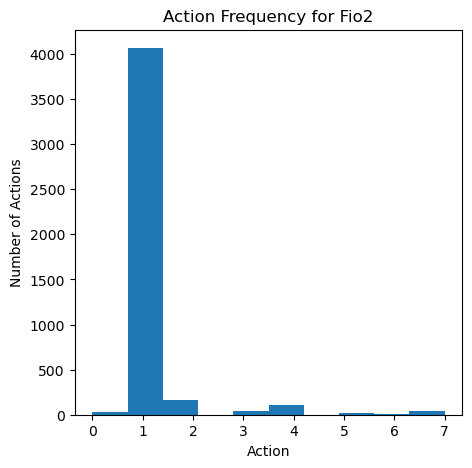

In [17]:
plot_actions_hist(df, 'fio2')

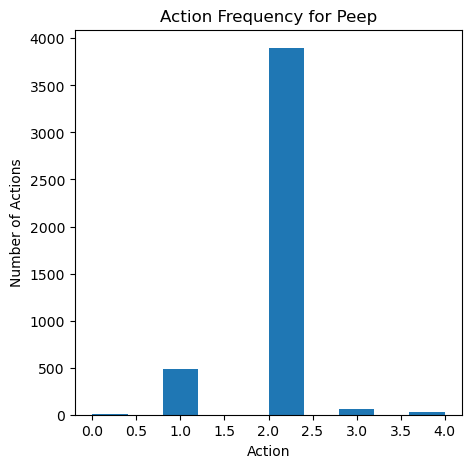

In [18]:
plot_actions_hist(df, 'peep')

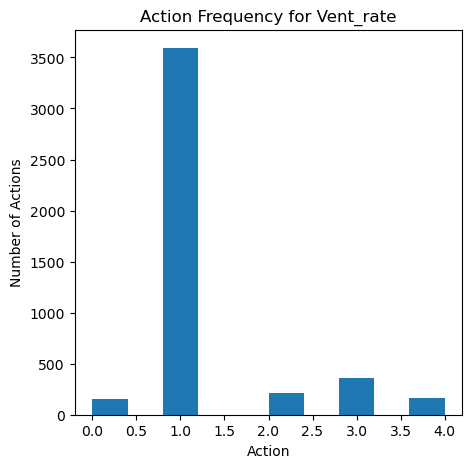

In [19]:
plot_actions_hist(df, 'vent_rate')

## Plot Average Reward Return Between Patients Who Survived Vs Died

In [20]:
survived_df = df.loc[~df['csn'].isin(mort_csns)]
died_df = df.loc[df['csn'].isin(mort_csns)]

survived_rewards = survived_df.groupby('csn', as_index=False)['short_term_reward'].sum() + 10
died_rewards = died_df.groupby('csn', as_index=False)['short_term_reward'].sum() - 10

survived_rewards.rename(columns={'short_term_reward': 'total_reward'}, inplace=True)
died_rewards.rename(columns={'short_term_reward': 'total_reward'}, inplace=True)

print(f"Number of patients who survived: {len(survived_rewards)}")
print(f"Number of patients who died: {len(died_rewards)}")
print(f"Average reward for patients who survived: {survived_rewards['total_reward'].mean()}")
print(f"Average reward for patients who died: {died_rewards['total_reward'].mean()}")

Number of patients who survived: 66
Number of patients who died: 11
Average reward for patients who survived: 9.833333333333334
Average reward for patients who died: -9.909090909090908
